In [1]:

!pip install kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:

!unzip brain-tumor-image-dataset-semantic-segmentation.zip

Archive:  brain-tumor-image-dataset-semantic-segmentation.zip
  inflating: README.txt              
  inflating: test/1030_jpg.rf.4bfc0ebc72d835cb9668219cd911c249.jpg  
  inflating: test/1035_jpg.rf.0dead1ccbe6b1e137ca2d98fc4d34b9a.jpg  
  inflating: test/1056_jpg.rf.f539615badbea313d68c957e76642dda.jpg  
  inflating: test/1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg  
  inflating: test/1083_jpg.rf.b1473a76f8f3789c6be693dfbe9bc011.jpg  
  inflating: test/1093_jpg.rf.4cde54a1271fe5ecc1f9d6ca4b00f835.jpg  
  inflating: test/1125_jpg.rf.6a2f54deeac86ff2d961132a828c9ae6.jpg  
  inflating: test/1126_jpg.rf.d216bd33f5b8f7f557d14928c232a377.jpg  
  inflating: test/1130_jpg.rf.d1672624856f1df581acc128aea4a635.jpg  
  inflating: test/1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg  
  inflating: test/1140_jpg.rf.f8a48ff0879568ff23cd511711ef650e.jpg  
  inflating: test/1151_jpg.rf.17b666e0803c2fcd6b5b292fadf7afd5.jpg  
  inflating: test/1174_jpg.rf.336d0729fe53adf926746fe2fe9cd0df.jpg  
  i

In [ ]:
# Estructura del DF
import json

def print_structure (d, indent=0):
    if isinstance(d,dict):
        for key , value in d.items():
            print(' ' * indent + str(key))
            print_structure(value,indent+1)
    elif isinstance(d, list):
        print(' ' * indent + "list of length {} containing : ".format(len(d)))
        if d:
            print_structure(d[0],indent+1)

with open('/content/valid/_annotations.coco.json','r') as file:
    data = json.load(file)

print_structure(data)

info
 year
 version
 description
 contributor
 url
 date_created
licenses
 list of length 1 containing : 
  id
  url
  name
categories
 list of length 3 containing : 
  id
  name
  supercategory
images
 list of length 429 containing : 
  id
  license
  file_name
  height
  width
  date_captured
annotations
 list of length 429 containing : 
  id
  image_id
  category_id
  bbox
   list of length 4 containing : 
  area
  segmentation
   list of length 1 containing : 
    list of length 10 containing : 
  iscrowd


In [ ]:
from pycocotools.coco import COCO

In [ ]:
train_dir = '/content/train'
val_dir = '/content/valid'
test_dir = '/content/test'

train_annotation_file = '/content/train/_annotations.coco.json'
test_annotation_file = '/content/test/_annotations.coco.json'
val_annotation_file = '/content/valid/_annotations.coco.json'

In [ ]:
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Pipeline de preprocesamiento

In [ ]:
import os
from PIL import Image
import numpy as np
from pycocotools.coco import COCO

def load_image_and_mask(coco, image_dir, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = Image.open(image_path)
    image = np.array(image)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((image_info['height'], image_info['width']))
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

    return tf.data.Dataset.from_generator(generator,
                                          output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                                                            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)))

train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

In [ ]:
import tensorflow as tf

def preprocess(image, mask):

    image = tf.image.resize(image, (512, 512))

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (512, 512), method='nearest')

    image = tf.cast(image, tf.float32) / 255.0

    return image, mask

train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

In [ ]:

img_ids = train_coco.getImgIds()

for i, img_id in enumerate(img_ids[:1]):

    img_info = train_coco.loadImgs(img_id)[0]

    filename = img_info['file_name']
    height = img_info['height']
    width = img_info['width']

    print(f"Archivo: {filename}, Dimensiones: {height}x{width}")

Archivo: 2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg, Dimensiones: 640x640


# Metricas

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

In [ ]:
def tversky_loss(y_true, y_pred, smooth=1e-6, alpha=0.3, beta=0.7):
    y_true_pos = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_pos = K.flatten(y_pred)

    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    # Índice Tversky
    numerator = true_pos + smooth
    denominator = true_pos + alpha * false_pos + beta * false_neg + smooth

    # Pérdida Tversky (1 - Índice)
    return 1 - (numerator / denominator)

# Aumentacion de Datos

In [ ]:
!pip install albumentations==1.4.3 opencv-python-headless==4.10.0.84


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [ ]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from pycocotools.coco import COCO
import albumentations as A

augment = A.Compose([
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

In [ ]:
def patch_generator(coco, image_dir, image_ids, patch_size=(256, 256), patches_per_image=10, tumor_ratio=0.8):

    H, W = patch_size

    # Cargar una imagen y máscara (como en su código original)
    def load_full_image_and_mask(image_id):
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB') # Asegurar 3 canales
        image = np.array(image)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((image_info['height'], image_info['width']))
        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann))

        # Redimensionar a 512x512 (estandarizar tamaño antes de parchear)
        image = tf.image.resize(image, (512, 512)).numpy().astype(np.uint8)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.resize(mask, (512, 512), method='nearest').numpy().astype(np.uint8)

        return image, mask

    # Loop principal del generador
    while True:
        np.random.shuffle(image_ids) # Mezclar imágenes en cada época

        for image_id in image_ids:
            image_full, mask_full = load_full_image_and_mask(image_id)

            patches_generated = 0
            while patches_generated < patches_per_image:
                # Coordenadas aleatorias
                x = np.random.randint(0, 512 - W)
                y = np.random.randint(0, 512 - H)

                # Extraer parche
                patch_mask = mask_full[y:y+H, x:x+W]

                # Estrategia de Muestreo: Aceptar si (contiene tumor) O (pasa el ratio aleatorio)
                has_tumor = np.sum(patch_mask) > 0
                is_background_sample = np.random.rand() > tumor_ratio # ej. 20% de prob

                if has_tumor or is_background_sample:
                    patch_img = image_full[y:y+H, x:x+W]

                    # Aplicar aumentación de Albumentations
                    augmented = augment(image=patch_img, mask=patch_mask.squeeze())
                    aug_img = augmented['image']
                    aug_mask = augmented['mask']

                    # Normalizar y formatear
                    aug_img = tf.cast(aug_img, tf.float32) / 255.0
                    aug_mask = tf.expand_dims(tf.cast(aug_mask, tf.uint8), axis=-1) # Re-expandir dims

                    yield aug_img, aug_mask
                    patches_generated += 1

# --- Creación de los Datasets ---
PATCH_SIZE = (256, 256)
BATCH_SIZE = 16 # <-- Aumentamos el Batch Size gracias a los patches

# (Cargue sus objetos COCO aquí)
train_ids = train_coco.getImgIds()
val_ids = val_coco.getImgIds()
test_ids = test_coco.getImgIds()

# Datasets de TF
output_sig = (
    tf.TensorSpec(shape=(*PATCH_SIZE, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(*PATCH_SIZE, 1), dtype=tf.uint8)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(train_coco, train_dir, train_ids, patch_size=PATCH_SIZE, tumor_ratio=0.8),
    output_signature=output_sig
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Para validación, es mejor usar menos parches y un ratio 0.5/0.5
val_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(val_coco, val_dir, val_ids, patch_size=PATCH_SIZE, patches_per_image=4, tumor_ratio=0.5),
    output_signature=output_sig
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Para test, usamos la misma lógica que validación
test_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(test_coco, test_dir, test_ids, patch_size=PATCH_SIZE, patches_per_image=4, tumor_ratio=0.5),
    output_signature=output_sig
)

In [ ]:
def augment_data(image, mask):
    def _augment(image_np, mask_np):
        image_np = image_np.numpy()
        mask_np = mask_np.numpy()

        augmented = augment(image=image_np, mask=mask_np)
        return augmented['image'], augmented['mask']

    image, mask = tf.py_function(
        func=_augment,
        inp=[image, mask],
        Tout=[tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), tf.TensorSpec(shape=(None, None), dtype=tf.uint8)] # Specify expected shapes and dtypes
    )

    image.set_shape([None, None, 3])
    mask.set_shape([None, None])
    return image, mask

In [ ]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, num_samples=3):
    for images, masks in dataset.take(num_samples):
        # Si las imágenes vienen en batch, itera dentro del batch
        for i in range(images.shape[0]):
            plt.figure(figsize=(10, 5))

            # Imagen original
            plt.subplot(1, 2, 1)
            plt.imshow(images[i].numpy())
            plt.title("Imagen")
            plt.axis("off")

            # Máscara correspondiente
            plt.subplot(1, 2, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
            plt.title("Máscara")
            plt.axis("off")

            plt.show()


In [ ]:
train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

# Aumentacion + preprocesamiento
train_dataset = (
    train_dataset
    .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(100)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

# Validacion y test sin augmentacion
val_dataset = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
)


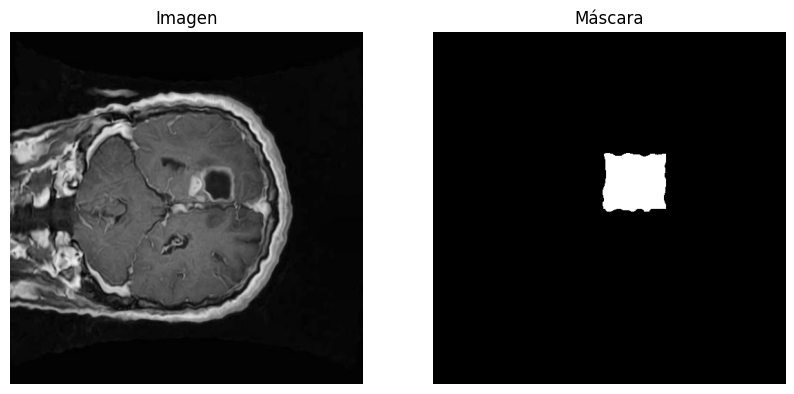

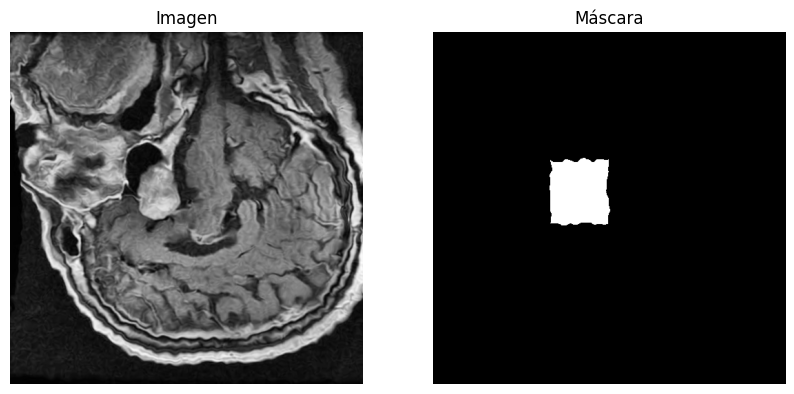

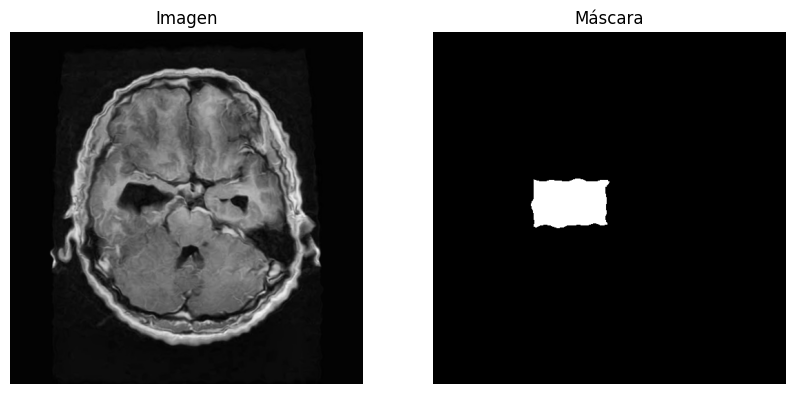

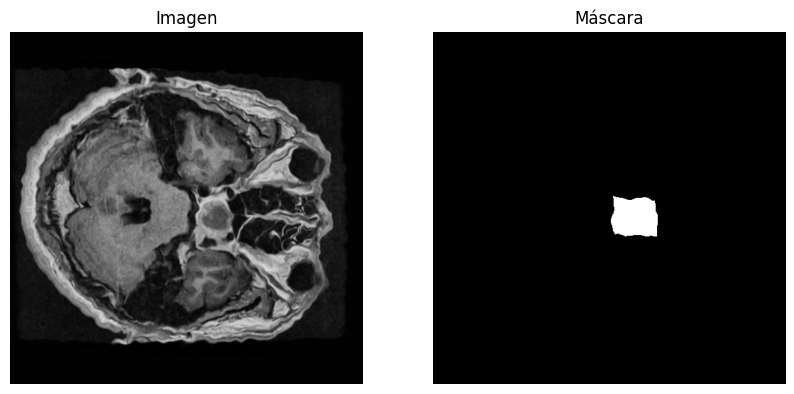

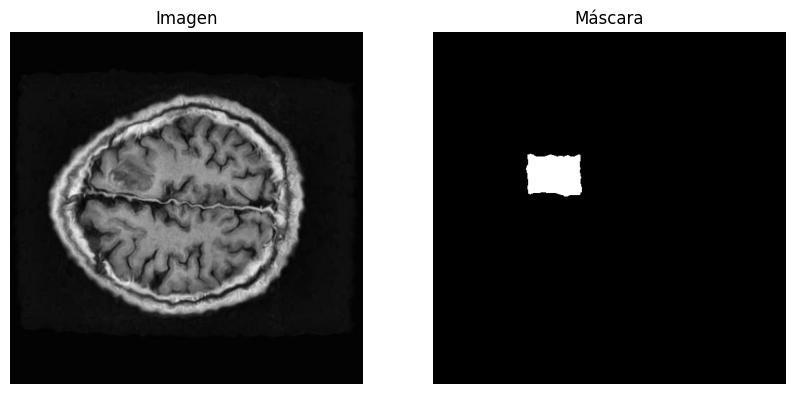

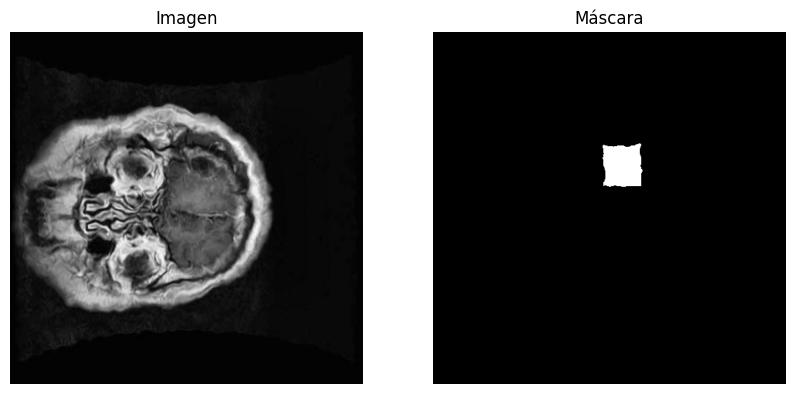

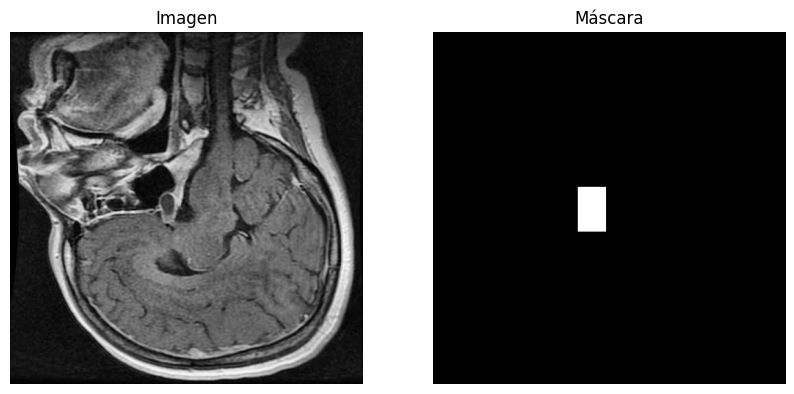

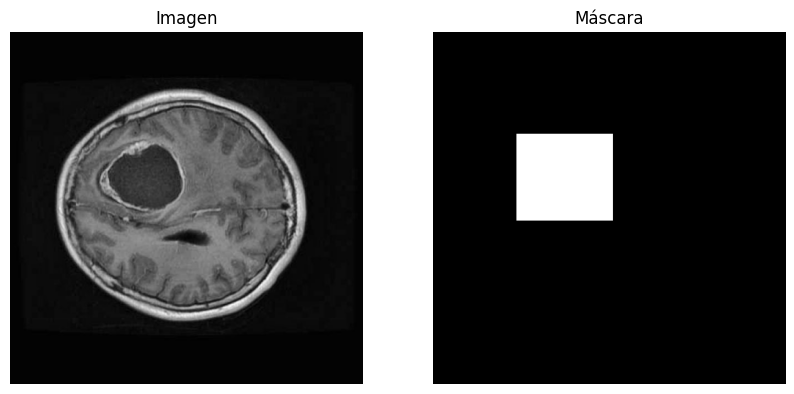

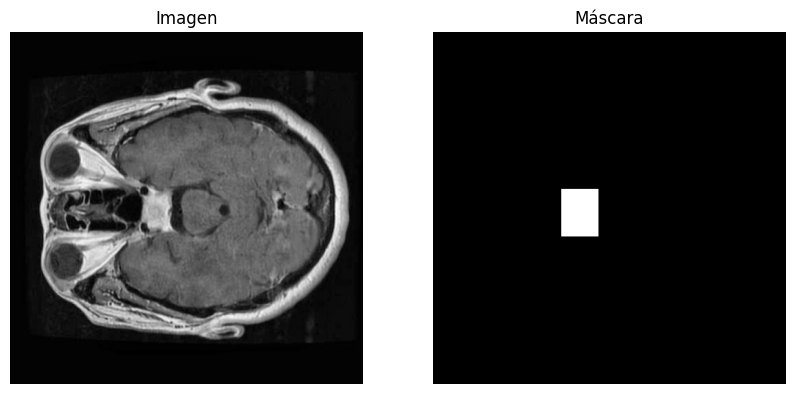

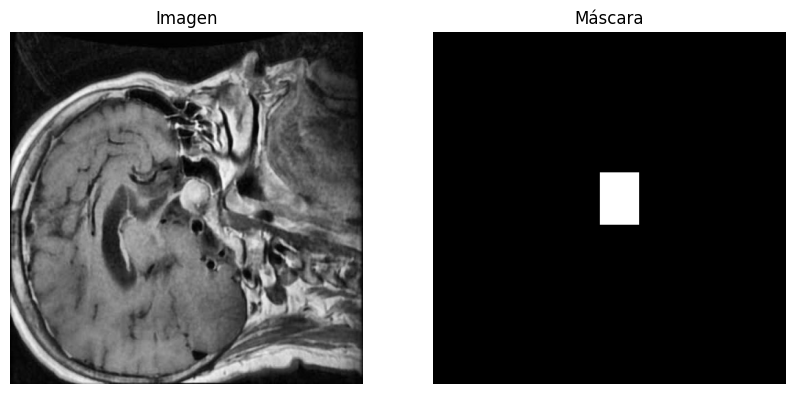

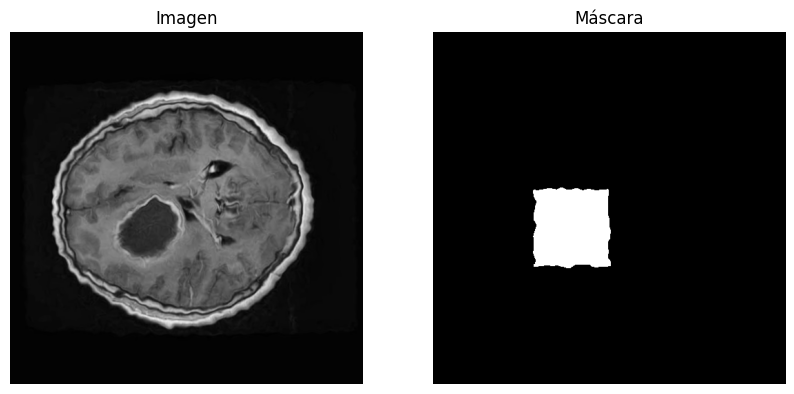

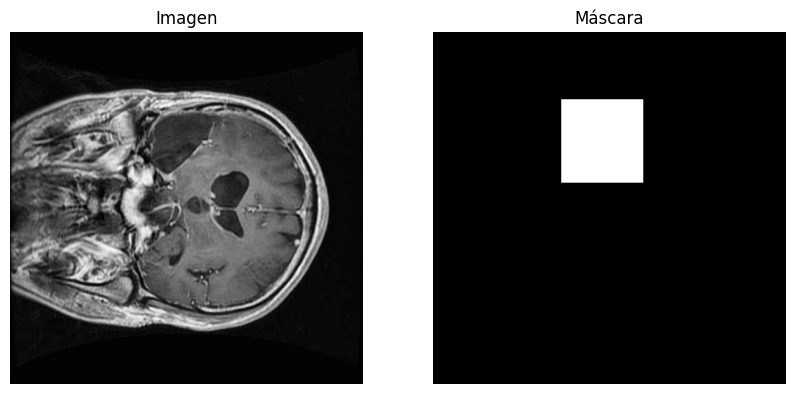

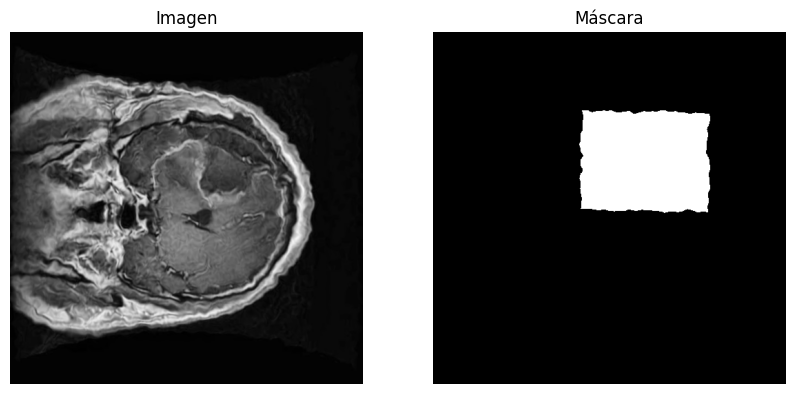

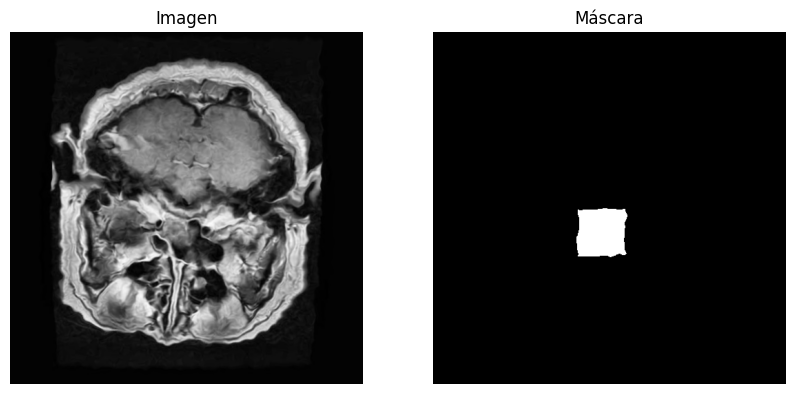

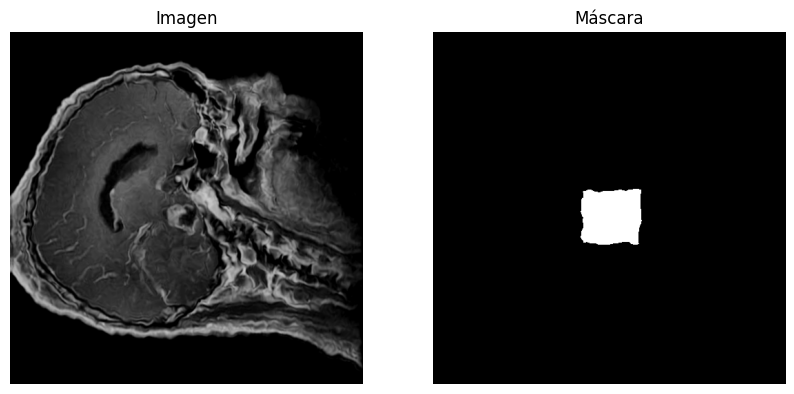

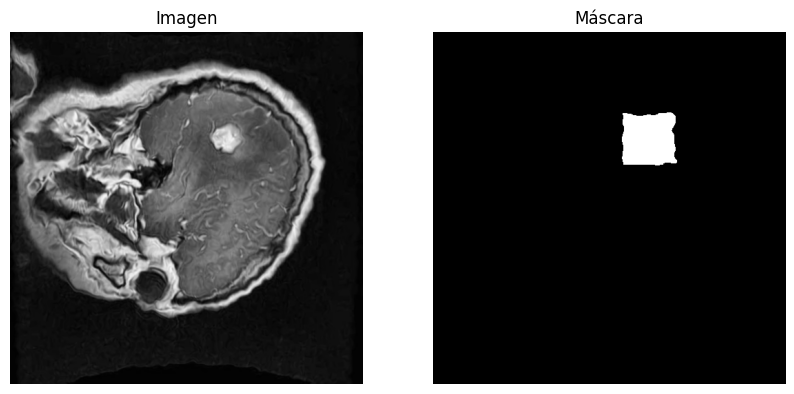

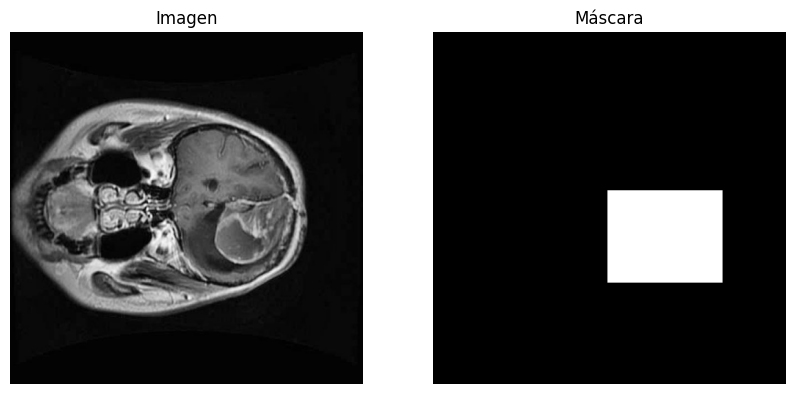

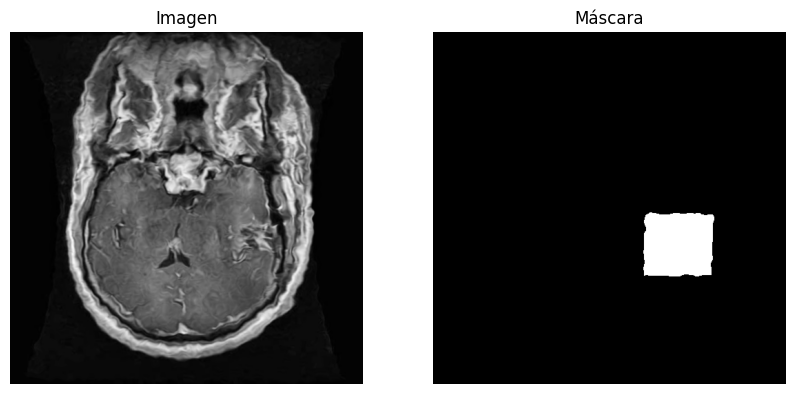

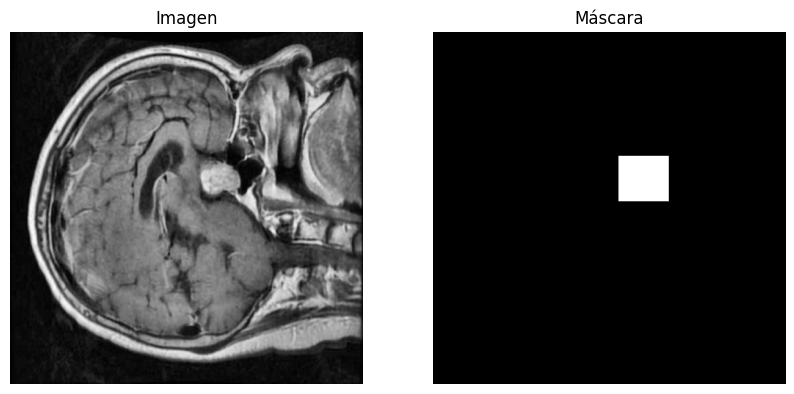

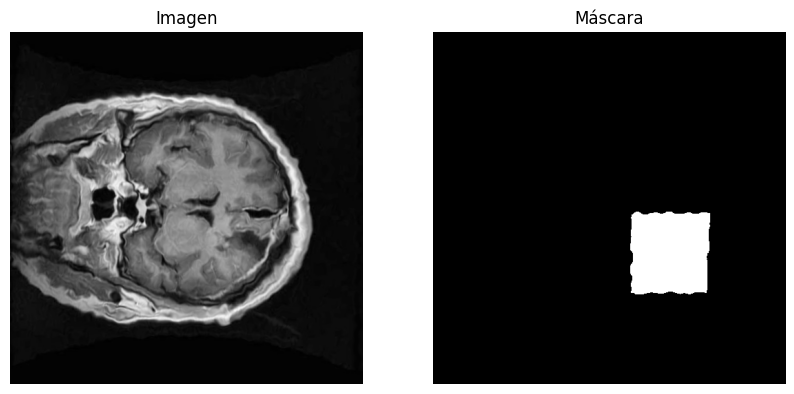

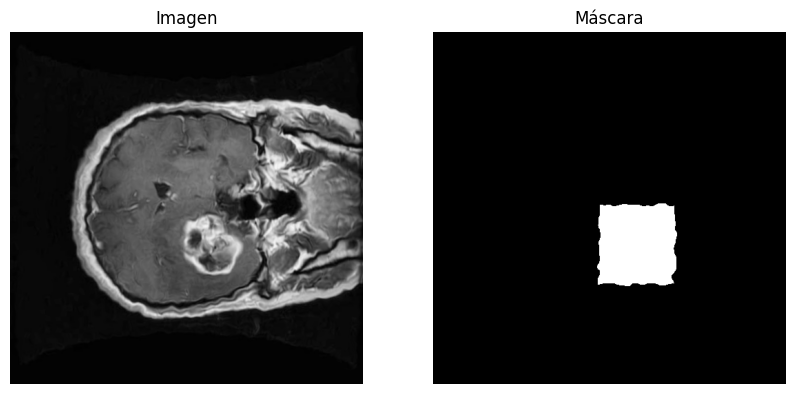

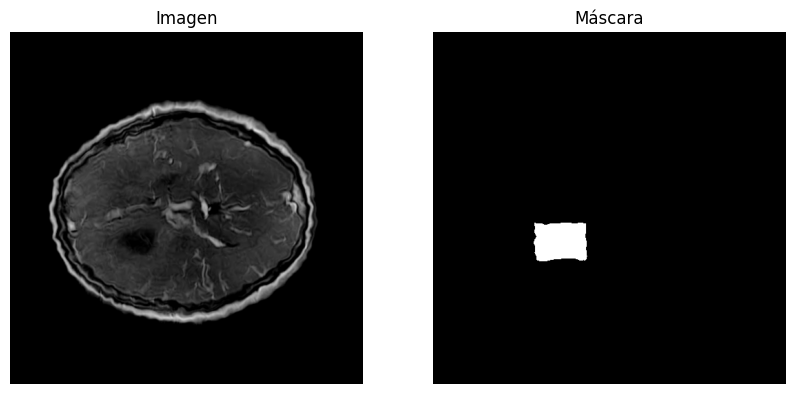

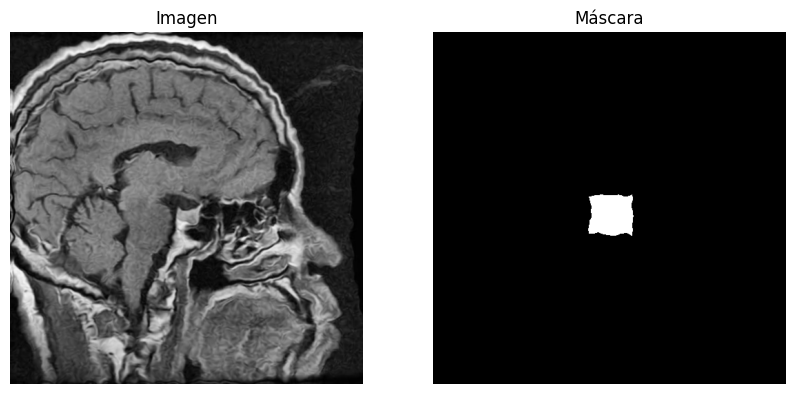

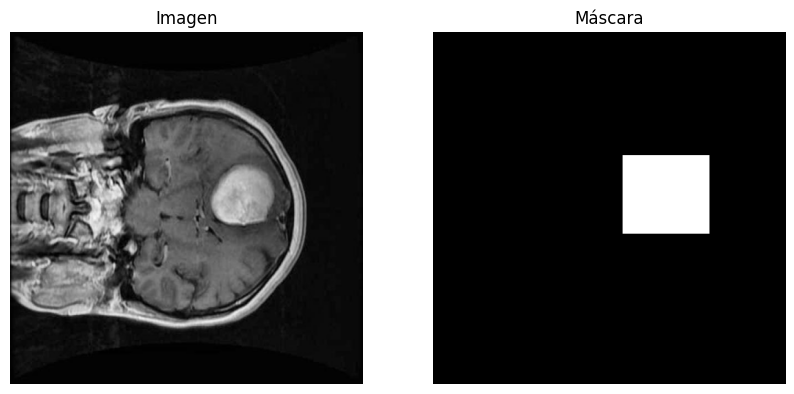

In [ ]:
visualize_dataset(train_dataset.take(3))

# Modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import ReLU, BatchNormalization, Activation, Input, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.layers import DepthwiseConv2D

In [ ]:
# Bloque de Convolución Profundamente Separable

def ds_block(x, filters, kernel_size=(3, 3), padding="same"):
    # 1. Convolución Profunda (Depthwise)
    # Usa DepthwiseConv2D.
    x = DepthwiseConv2D(kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 2. Convolución Puntual
    # Usa Conv2D con un kernel de 1x1. Es la que define el número final de 'filters'.
    x = Conv2D(filters, (1, 1), padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
# Bloque de Atención

def attention_gate(g, x, filters):
    # g: señal del Decodificador
    # x: señal del Codificador (skip connection)

    # 1. Proyectar g y x al mismo espacio de baja dimensión
    g_conv = Conv2D(filters, (1, 1), padding='same')(g)
    x_conv = Conv2D(filters, (1, 1), padding='same')(x)

    # 2. Sumar y aplicar ReLU
    sum_relu = ReLU()(Add()([g_conv, x_conv]))

    # 3. Mapear la atencion
    psi = Conv2D(1, (1, 1), padding='same')(sum_relu)
    attention_map = Activation('sigmoid')(psi)

    # 4. Multiplicar el mapa de atención por la señal de entrada (x)
    return Multiply()([x, attention_map])


In [ ]:
# Ensamblaje de la Attn-DS-UNet

def attn_ds_unet(input_shape, num_classes=1, start_filters=32):

    inputs = Input(input_shape)

    #  CODIFICADOR (contraccion)
    # Nivel 0
    c0 = Conv2D(start_filters, (3, 3), padding='same', activation='relu')(inputs)
    c0 = ds_block(c0, start_filters)

    # Nivel 1
    c1 = MaxPool2D((2, 2))(c0)
    c1 = ds_block(c1, start_filters * 2)

    # Nivel 2
    c2 = MaxPool2D((2, 2))(c1)
    c2 = ds_block(c2, start_filters * 4)

    # Nivel 3
    c3 = MaxPool2D((2, 2))(c2)
    c3 = ds_block(c3, start_filters * 8)

    #  BOTTLENECK
    b = MaxPool2D((2, 2))(c3)
    b = ds_block(b, start_filters * 16)

    #  DECODIFICADOR (Expansión)
    # Nivel 3 (Expansión)
    u3 = Conv2DTranspose(start_filters * 8, (2, 2), strides=(2, 2), padding='same')(b)
    a3 = attention_gate(u3, c3, start_filters * 8) # Aplicar Atención
    u3 = concatenate([u3, a3])
    u3 = ds_block(u3, start_filters * 8)

    # Nivel 2 (Expansión)
    u2 = Conv2DTranspose(start_filters * 4, (2, 2), strides=(2, 2), padding='same')(u3)
    a2 = attention_gate(u2, c2, start_filters * 4) # Aplicar Atención
    u2 = concatenate([u2, a2])
    u2 = ds_block(u2, start_filters * 4)

    # Nivel 1 (Expansión)
    u1 = Conv2DTranspose(start_filters * 2, (2, 2), strides=(2, 2), padding='same')(u2)
    a1 = attention_gate(u1, c1, start_filters * 2) # Aplicar Atención
    u1 = concatenate([u1, a1])
    u1 = ds_block(u1, start_filters * 2)

    # Nivel 0 (Expansión)
    u0 = Conv2DTranspose(start_filters, (2, 2), strides=(2, 2), padding='same')(u1)
    a0 = attention_gate(u0, c0, start_filters) # Aplicar Atención
    u0 = concatenate([u0, a0])
    u0 = ds_block(u0, start_filters)

    #  CAPA DE SALIDA
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid', dtype='float32')(u0)

    return Model(inputs=inputs, outputs=outputs)



In [ ]:
input_size = (*PATCH_SIZE, 3)
model = attn_ds_unet(input_size, start_filters=32)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 512, 512,  │        320 │ conv2d[0][0]      │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      1,056 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 256, 256,  │        320 │ max_pooling2d[0]… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      2,112 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 128, 128,  │        640 │ max_pooling2d_1[

 Total params: 1,250,405 (4.77 MB)

 Trainable params: 1,244,517 (4.75 MB)

 Non-trainable params: 5,888 (23.00 KB)

# Entrenamiento

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Política actual:", mixed_precision.global_policy())


Política actual: <DTypePolicy "mixed_float16">


In [ ]:
try:
    print("Cargando pesos del modelo anterior (best_model.h5)...")
    model.load_weights('best_model.h5')
    print("Pesos cargados exitosamente. Iniciando re-entrenamiento (warm-start).")
except Exception as e:
    print(f"Error al cargar pesos: {e}. El modelo entrenará desde cero.")

Cargando pesos del modelo anterior (best_model.h5)...
Pesos cargados exitosamente. Iniciando re-entrenamiento (warm-start).


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=tversky_loss,
    metrics=[dice_coef]
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_dice_coef',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.5,
    patience=5,
    mode='max',
    min_lr=1e-6,
    verbose=1
)


In [ ]:
# Entrenamiento
# Nota: steps_per_epoch y validation_steps son necesarios para generadores infinitos
steps_per_epoch = len(train_ids) * 10 // BATCH_SIZE # (Imágenes * parches_por_imagen) / batch
validation_steps = len(val_ids) * 4 // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/40
    188/Unknown 279s 1s/step - dice_coef: 0.4859 - loss: 0.5141   

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_dice_coef improved from -inf to 0.38124, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - dice_coef: 0.4860 - loss: 0.5140 - val_dice_coef: 0.3812 - val_loss: 0.6196 - learning_rate: 5.0000e-05
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - dice_coef: 0.5012 - loss: 0.4988
Epoch 2: val_dice_coef improved from 0.38124 to 0.51071, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 162s 825ms/step - dice_coef: 0.5012 - loss: 0.4988 - val_dice_coef: 0.5107 - val_loss: 0.4898 - learning_rate: 5.0000e-05
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - dice_coef: 0.4939 - loss: 0.5061
Epoch 3: val_dice_coef improved from 0.51071 to 0.52792, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 162s 826ms/step - dice_coef: 0.4939 - loss: 0.5061 - val_dice_coef: 0.5279 - val_loss: 0.4731 - learning_rate: 5.0000e-05
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - dice_coef: 0.5052 - loss: 0.4948
Epoch 4: val_dice_coef did not improve from 0.52792
188/188 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - dice_coef: 0.5052 - loss: 0.4948 - val_dice_coef: 0.5051 - val_loss: 0.4949 - learning_rate: 5.0000e-05
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - dice_coef: 0.5023 - loss: 0.4977
Epoch 5: val_dice_coef improved from 0.52792 to 0.54259, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - dice_coef: 0.5023 - loss: 0.4977 - val_dice_coef: 0.5426 - val_loss: 0.4584 - learning_rate: 5.0000e-05
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - dice_coef: 0.5155 - loss: 0.4845
Epoch 6: val_dice_coef did not improve from 0.54259
188/188 ━━━━━━━━━━━━━━━━━━━━ 169s 861ms/step - dice_coef: 0.5155 - loss: 0.4845 - val_dice_coef: 0.3705 - val_loss: 0.6298 - learning_rate: 5.0000e-05
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - dice_coef: 0.5167 - loss: 0.4833
Epoch 7: val_dice_coef did not improve from 0.54259
188/188 ━━━━━━━━━━━━━━━━━━━━ 158s 813ms/step - dice_coef: 0.5167 - loss: 0.4833 - val_dice_coef: 0.4166 - val_loss: 0.5837 - learning_rate: 5.0000e-05
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - dice_coef: 0.5226 - loss: 0.4774
Epoch 8: val_dice_coef did not improve from 0.54259
188/188 ━━━━━━━━━━━━━━━━━━━━ 162s 834ms/step - dice_coef: 0.5226 - loss: 0.4774 - val_dice_coef: 0.5104 - val_loss: 0.4901 - le

188/188 ━━━━━━━━━━━━━━━━━━━━ 159s 819ms/step - dice_coef: 0.5238 - loss: 0.4762 - val_dice_coef: 0.5500 - val_loss: 0.4507 - learning_rate: 5.0000e-05
Epoch 10/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - dice_coef: 0.5244 - loss: 0.4756
Epoch 10: val_dice_coef did not improve from 0.54996
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 821ms/step - dice_coef: 0.5244 - loss: 0.4756 - val_dice_coef: 0.5204 - val_loss: 0.4805 - learning_rate: 5.0000e-05
Epoch 11/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - dice_coef: 0.5253 - loss: 0.4747
Epoch 11: val_dice_coef did not improve from 0.54996
188/188 ━━━━━━━━━━━━━━━━━━━━ 162s 829ms/step - dice_coef: 0.5254 - loss: 0.4746 - val_dice_coef: 0.4457 - val_loss: 0.5547 - learning_rate: 5.0000e-05
Epoch 12/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - dice_coef: 0.5278 - loss: 0.4722
Epoch 12: val_dice_coef improved from 0.54996 to 0.57358, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 167s 855ms/step - dice_coef: 0.5279 - loss: 0.4721 - val_dice_coef: 0.5736 - val_loss: 0.4270 - learning_rate: 5.0000e-05
Epoch 13/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - dice_coef: 0.5253 - loss: 0.4747
Epoch 13: val_dice_coef did not improve from 0.57358
188/188 ━━━━━━━━━━━━━━━━━━━━ 198s 835ms/step - dice_coef: 0.5253 - loss: 0.4747 - val_dice_coef: 0.5303 - val_loss: 0.4702 - learning_rate: 5.0000e-05
Epoch 14/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - dice_coef: 0.5346 - loss: 0.4654
Epoch 14: val_dice_coef did not improve from 0.57358
188/188 ━━━━━━━━━━━━━━━━━━━━ 164s 837ms/step - dice_coef: 0.5347 - loss: 0.4653 - val_dice_coef: 0.5421 - val_loss: 0.4593 - learning_rate: 5.0000e-05
Epoch 15/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - dice_coef: 0.5405 - loss: 0.4595
Epoch 15: val_dice_coef did not improve from 0.57358
188/188 ━━━━━━━━━━━━━━━━━━━━ 165s 843ms/step - dice_coef: 0.5405 - loss: 0.4595 - val_dice_coef: 0.5580 - val_loss: 0.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
# mantemos para ver si hay cambios con o sin ruido
test_results = model.evaluate(test_dataset)
print(f"\nTest Dice Coefficient: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")


In [ ]:

print("\nEvaluando modelo con limpieza de ruido...")

def clean_noise(mask, min_area=20):
    # 'mask' es (256, 256, 1), binaria (0 o 1)
    mask_uint8 = (mask * 255).astype(np.uint8).squeeze() # Convertir a formato CV2

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, 4, cv2.CV_32S)

    cleaned_mask = np.zeros_like(mask_uint8)

    # Empezar en 1 para ignorar el fondo (label 0)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned_mask[labels == i] = 1 # Mantener componente

    return np.expand_dims(cleaned_mask, axis=-1)

# Bucle de evaluación manual
all_dice_scores = []
# Volver a crear el dataset de test sin .batch() para iterar 1 por 1
test_dataset_unbatched = tf.data.Dataset.from_generator(
    lambda: patch_generator(test_coco, test_dir, test_ids, patch_size=PATCH_SIZE, patches_per_image=4, tumor_ratio=0.5),
    output_signature=output_sig
)

# Iterar
for img, mask_true in test_dataset_unbatched:
    # Predecir
    mask_pred = model.predict(np.expand_dims(img, axis=0))[0] # (1, 256, 256, 1) -> (256, 256, 1)
    mask_pred_binary = (mask_pred > 0.5).astype(np.uint8)

    # Limpiar Ruido
    mask_pred_cleaned = clean_noise(mask_pred_binary, min_area=20)

    # Calcular métrica
    score = dice_coef(mask_true, mask_pred_cleaned)
    all_dice_scores.append(score)

print(f"\nTest Dice Coefficient (Limpio): {np.mean(all_dice_scores):.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_samples=3):
    # Take num_samples images from the dataset
    for images, masks in dataset.unbatch().take(num_samples).batch(num_samples):
        preds = model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)

        for i in range(num_samples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Imagen")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i], cmap="gray")
            plt.title("Máscara real")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[i], cmap="gray")
            plt.title("Predicción")
            plt.axis("off")

            plt.show()

visualize_predictions(test_dataset, model)